**Bayesian Optimization with GPyOpt**  
**This example only show how the GPyOpt API work**

Try to find optimal hyperparameters to XGBoost model using Bayesian optimization with GP, with the diabetes dataset (from sklearn) as input. Let’s first load the dataset with the following python code snippet:

In [4]:
from sklearn import datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
dataset = datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

In [5]:
# Optimizer will try to find minimum, so let's add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4]), 
        X, y, scoring='neg_root_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score
     
# Bounds (define continuous variables first, then discrete!)
bounds = [
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},
    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},
    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 50)},
    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 300)},
    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

Let’s find the baseline RMSE with default XGBoost parameters is . Let’s see if we can do better.

In [6]:
baseline = -cross_val_score(
    XGBRegressor(), X, y, scoring='neg_root_mean_squared_error'
).mean()
baseline
# 64.90693011829266

64.90693033120199

Now, run the Bayesian optimization with GPyOpt and plot convergence, as in the next code snippet:

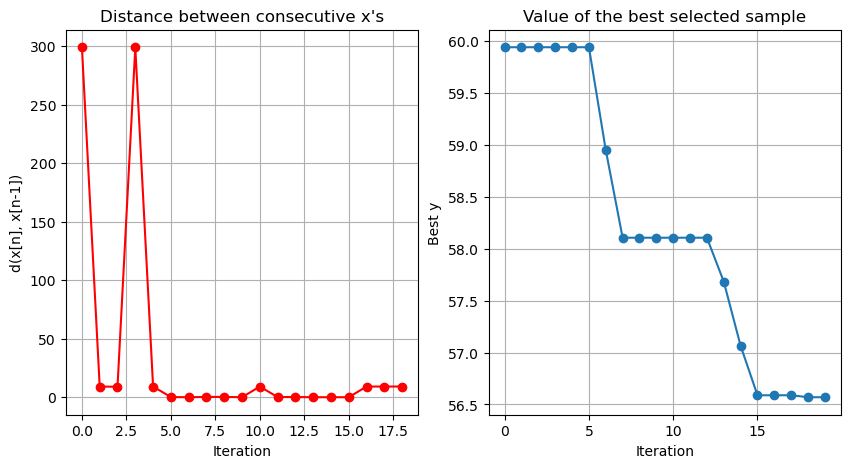

In [13]:
import numpy as np
import GPyOpt
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI', ## method to optimize the acq. function
    acquisition_par = 0.1,
    exact_eval=True
)
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)
optimizer.plot_convergence()

Extract the best values of the parameters and compute the RMSE / gain obtained with Bayesian Optimization, using the following code.

In [26]:
optimizer.X[np.argmin(optimizer.Y)]
# array([2.01515532e-01, 1.35401092e+00, 1.00000000e+00, 
# 3.00000000e+02, 1.00000000e+00])

array([5.00047461e-02, 3.10049677e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+01])

In [25]:
print('RMSE:', np.min(optimizer.Y),
      'Gain:', baseline/np.min(optimizer.Y)*100)
# RMSE: 57.6844355488563 Gain: 112.52069904249859

RMSE: 56.1566484514227 Gain: 125.44111632088877


Paramerter Tuning for SVR

-Now, let’s tune a Support Vector Regressor model with Bayesian Optimization and find the optimal values for three parameters: C, epsilon and gamma.

-Let’s use range (1e-5, 1000) for C, (1e-5, 10) for epsilon and gamma.

-Let’s use MPI as an acquisition function with weight 0.1.

70.44352670586173
RMSE: 56.1566484514227 Gain: 125.44111632088877


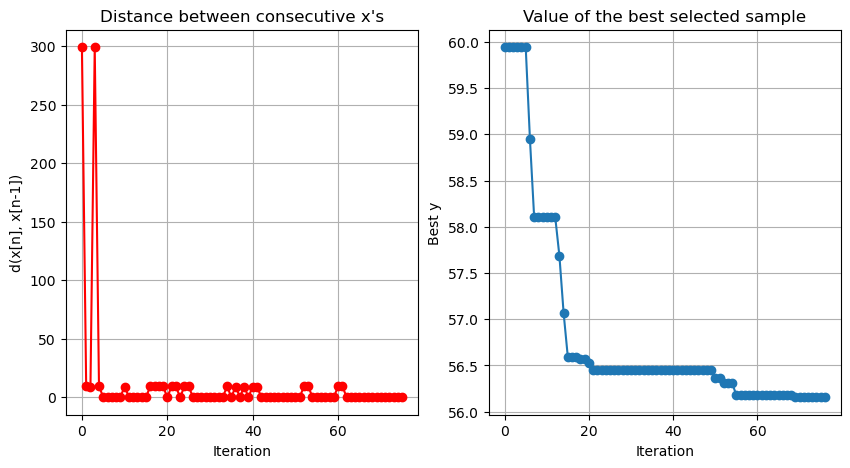

In [18]:
from sklearn.svm import SVR# Bounds (define continuous variables first, then discrete!)
bounds = [
    {'name': 'C',
     'type': 'continuous',
     'domain': (1e-5, 1000)},    {'name': 'epsilon',
     'type': 'continuous',
     'domain': (1e-5, 10)},    {'name': 'gamma',
     'type': 'continuous',
     'domain': (1e-5, 10)}
]
 
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        SVR(C = parameters[0],
            epsilon = parameters[1],
            gamma = parameters[2]), 
        X, y, scoring='neg_root_mean_squared_error'
    ).mean()
    score = np.array(score)
    scoreoptimizer = GPyOpt.methods.BayesianOptimization(
            f=f, domain=bounds,
            acquisition_type ='MPI',
            acquisition_par = 0.1,
            exact_eval=True
            )
    return scoreoptimizer

max_iter = 50*4
max_time = 60*4

optimizer.run_optimization(max_iter, max_time)
baseline = -cross_val_score( SVR(), X, y, scoring='neg_root_mean_squared_error').mean()
print(baseline)

# 70.44352670586173print(optimizer.X[np.argmin(optimizer.Y)])
# [126.64337652   8.49323372   8.59189135]
print('RMSE:', np.min(optimizer.Y),
      'Gain:', baseline/np.min(optimizer.Y)*100)
# RMSE: 54.02576574389976 Gain: 130.38876124364006     best_epsilon = optimizer.X[np.argmin(optimizer.Y)][1] 
optimizer.plot_convergence()

Surrogate Function
The surrogate function is a technique used to best approximate the mapping of input examples to an output score.

## How to Implement Bayesian Optimization from Scratch in Python ##

https://machinelearningmastery.com/what-is-bayesian-optimization/

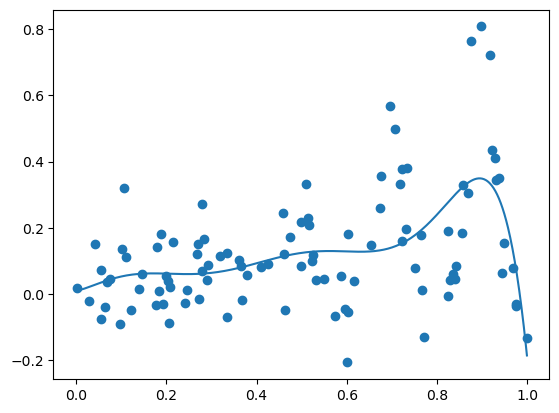

In [34]:
# example of a gaussian process surrogate function
from math import sin
from math import pi
from numpy import arange
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from matplotlib import pyplot
from warnings import catch_warnings
from warnings import simplefilter
from sklearn.gaussian_process import GaussianProcessRegressor

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot the surrogate function
plot(X, y, model)

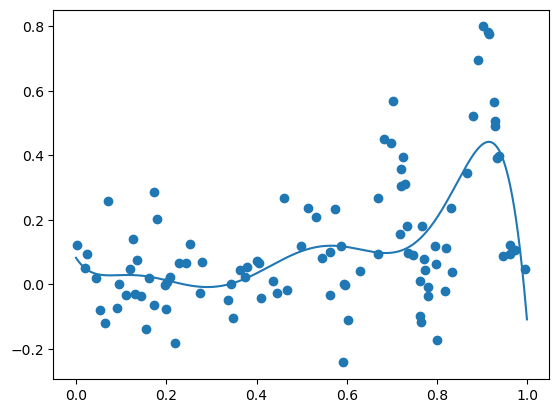

>x=0.753, f()=0.130899, actual=0.202
>x=0.914, f()=0.441535, actual=0.830
>x=0.914, f()=0.468772, actual=0.614
>x=0.448, f()=0.072738, actual=0.213
>x=0.255, f()=-0.005875, actual=-0.006
>x=0.546, f()=0.125458, actual=0.071
>x=0.644, f()=0.099045, actual=-0.099
>x=0.546, f()=0.115388, actual=0.125
>x=0.913, f()=0.480679, actual=0.718
>x=0.724, f()=0.094843, actual=0.413
>x=0.108, f()=0.029385, actual=-0.000
>x=0.366, f()=0.019852, actual=0.169
>x=0.935, f()=0.466089, actual=0.308
>x=0.912, f()=0.484408, actual=0.802
>x=0.913, f()=0.501859, actual=0.812
>x=0.846, f()=0.379995, actual=0.132
>x=0.661, f()=0.088295, actual=0.177
>x=0.383, f()=0.037196, actual=-0.013
>x=0.113, f()=0.026929, actual=-0.118
>x=0.981, f()=0.147262, actual=-0.012
>x=0.868, f()=0.436012, actual=0.285
>x=0.911, f()=0.503125, actual=0.739
>x=0.646, f()=0.095198, actual=-0.099
>x=0.355, f()=0.019695, actual=0.077
>x=0.535, f()=0.120008, actual=0.179
>x=0.729, f()=0.099606, actual=0.180
>x=0.913, f()=0.515075, actual

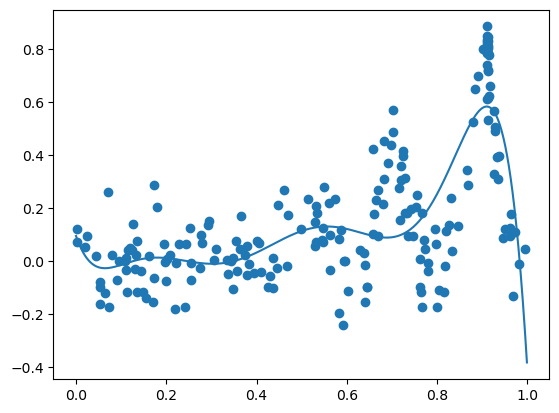

Best Result: x=0.911, y=0.884


In [35]:
# example of bayesian optimization for a 1d function from scratch
# this is pure gaussian bayesian optimization to find the next x to sampling...
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

# the true objective loss function??
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)

# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# if hyperparamters , here need to apply the paramters into the object function
    # sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

In this case, the model via mean 5-fold cross-validation

In [28]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

# generate 2d classification dataset
X, y = make_blobs(n_samples=500, centers=3, n_features=2)
# define the model
model = KNeighborsClassifier()
# define the space of hyperparameters to search
search_space = [Integer(1, 5, name='n_neighbors'), Integer(1, 2, name='p')]

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# something
	model.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(model, X, y, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate

# perform optimization
result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

Best Accuracy: 1.000
Best Parameters: n_neighbors=3, p=2


In [31]:
result.fun

0.0